# Building an Agentic System for YouTube Script Writing with LangGraph

## Introduction

Automating YouTube script writing is an ideal use case to showcase the power of agentic systems. In this article, we will build an agentic system step by step using LangGraph and LangChain, following an iterative approach.

We will use Mistral Small 3 as our primary LLM. This choice is strategic as agentic systems allow us to avoid relying on very large models like GPT-4o or Large Reasoning Models (LRMs) such as O1 or DeepSeek. With this approach, we can achieve advanced results while being more efficient in terms of computation and resources.

**Mistral Small 3** covers all our need for our agentic use case: 
- Low-latency function calling,
- robust structured output,
- competitive instuction following,
- fast-response conversational assistance,
- General Knowlegde performance that rivals models three times larger.

We will explore how to transition from a single LLM-based writing assistant to a multi-agent system capable of collaborating to produce a high-quality script.

## What You Will Learn
- The basics of agentic systems and why they matter
- How to create a **multi-agent** system with LangGraph
- How to evaluate agents and improve their quality
- How to use **Mistral Small 3** for efficient structured output
- How to implement a **supervisor** to coordinate agent collaboration

### **Understanding What an Agentic System Is (Collaboration of Agents, Not Just Function Calling)**

An **agentic system** is fundamentally about **collaboration between multiple autonomous agents** to accomplish a complex task. Unlike a traditional **function-calling approach**, where a single model or function sequentially processes inputs, an **agentic system** enables **distributed decision-making**, **specialized roles**, and **dynamic workflow adjustments** based on real-time results.

In this tutorial, we are **not focusing on function calling**, as it plays a minimal role in our implementation. Instead, we aim to build an **end-to-end agentic solution** with **fundamental capabilities**, showcasing how independent agents can work together in a structured, modular way.

### **Why Focus on the Basics?**
LangGraph’s official documentation often highlights **advanced features** such as:
- **Human-in-the-loop interventions** (where users can manually approve, edit, or intervene in workflows),
- **Memory management** (persistent state tracking across interactions),
- **Streaming outputs** (real-time updates from LLMs),
- **Complex multi-agent workflows** with intricate dependencies and decision-making.

These advanced features are **powerful but can overwhelm beginners** who are just getting started with **agentic systems**. 

### **The Goal of This Tutorial**
- Provide a **clear, accessible** introduction to **multi-agent system construction** using **LangGraph**.
- Focus on **core principles**: agent coordination, modularity, and workflow execution.
- **Avoid unnecessary complexity** while still demonstrating the **power of agentic architectures**.

This step-by-step approach ensures that **readers first master the fundamentals** before diving into **more advanced agentic capabilities**.

## Chapter 1: Understanding the Limitations of Classical Approaches

### The Problem with Classical Writing Assistants

Early iterations of writing assistants relied on a single LLM with a RAG knowledge base. Unfortunately, these systems had limitations:

- Excessive reliance on prompts
- Lack of coherence in the generated script
= Difficulty integrating user feedback

### Towards an Agentic Approach

Instead of asking a single model to handle everything, we will break down the writing process into multiple specific tasks assigned to specialized agents:

- **Planning**: Defining chapters and the overall script structure
- **Researcher**: Gathering relevant information
- **Writer**: Generating the content for each section
- **Reviewer**: Editing and validating the script
- **Supervisor**: Managing the workflow and final validation

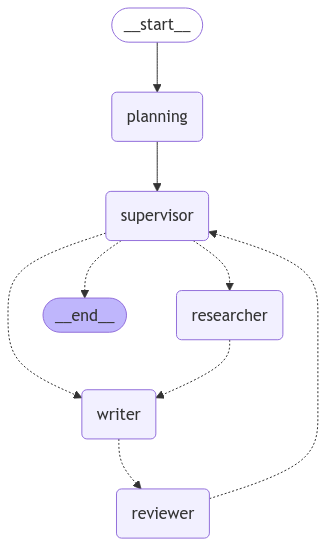

## Chapter 2: Introduction to LangChain Concepts

Before diving into LangGraph, it is crucial to understand the core LangChain concepts that will be used in nodes:

- **Prompt Templates**: Structuring effective prompts for agent interactions.
- **LLM with Structured Output**: Ensuring predictable responses.
- **LLM with Tools**: Allowing agents to interact with external sources.
- **Prompt Hub from LangSmith**: Reusing and managing prompts efficiently.

We will also explore how to test individual nodes before integrating them into a full graph-based workflow.

In [1]:
##############
# Import     #
##############
from typing import TypedDict, Literal, Annotated, List

from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_mistralai import ChatMistralAI



We now load LangChain MistralAI client that we will use throughout this notebook.

In [2]:
import getpass
import os


################
# AUTH KEY     #
################

# Import key from .env
_ = load_dotenv(find_dotenv())

# You'll need following key in you .env
# MISTRAL_API_KEY=vx...
# for LC Prompt Hub
# LANGCHAIN_API_KEY=lsv2_pt...


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("MISTRAL_API_KEY")
_set_env("LANGCHAIN_API_KEY")



In [3]:
################
# COMMON     #
################

# Mistral Small 3 available on Mistral AI 'La Platforme'
llm = ChatMistralAI(model="mistral-small-latest")



Here is the code of our first agent: the researcher.

In [4]:
####################
# RESEARCHER AGENT #
####################

# Define output format
class Research(TypedDict):
    research: str
    comment: str


researcher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""
            You are the **Researcher** in a team responsible for scriptwriting YouTube videos.
            Your role is to **gather, verify, and organize** relevant information to support scriptwriter in producing accurate and engaging content.  
            
            ### Responsibilities:
            - Provide **exhaustive, detailed, well-organized, contrasted and factual** information
            to feed the writer for all topics on the agenda. 
            - **No assumption or generic statements.** Only verifiable, specific facts or knowlegde.
            - **Incorporate feedback** to refine and improve your research.  
            - **You do not write the script.**
            - **You do not plan the agenda.**
            - **You do not review or make critics.**

            ### Constraint:
            The scriptwriter will not have access to any other source than your research.
            - Ensure that all necessary information is provided in your response.  
            - Do not assume the scriptwriter knows background details—explain key concepts where needed.  
            - Use reliable **sources** whenever possible to support claims.
            
            #### Expected Output Format:
            1. **Research**  
               - Organize your research with **numbered sections, subsections, bullet points, and hyphens** following the agenda for clarity.  
               - Include **sources** whenever possible.  
            2. **Comment**  
               - Use plain text to add **research notes** or respond to feedback.  
               - If informations are missing, state it here.
            
            #### Additional Notes:
            - Maintain a **clear and structured** format for readability.  
            - Avoid using **JSON, XML, or code-like formats.** Stick to plain text.  
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

researcher = researcher_prompt | llm.with_structured_output(Research)

This is a simple LLM chain with structured output. However, in real-world applications, you’ll likely need to extend it by integrating function calling or RAG (Retrieval-Augmented Generation) to enhance accuracy.

You can take inspiration from the [Research Team](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/?h=#research-team) of [Hierarchical Agent Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/?h=#hierarchical-agent-teams) on LangGraph Documentations.

We will keep 'research agent' as is for simplification.

Let's test this researcher agent. We define a conversation from a 'Human' and the 'Planner' .

In [20]:
# Emulate a conversation

input = [
        ("human", """I would like a two-chapter video, 2 minutes long, containing 450 words on the topic
            'AI will not take your job. Those who use AI will!'"""),
        ("assistant", """Here's a suggested agenda for your 2-chapter video on 'AI will not take your job. Those who use AI will!'

    ### Chapter 1
    1. **Title**
    AI will not take your job. Those who use AI will! (200 words):
    
    2. **Brief**
    Introduction of the video, presentation of the topic, and key points to be covered.
    
    3. **Covered Topics**
    - Understanding AI's role in the job market
    - The benefits of AI for workers
    - The skills needed to work with AI

    ### Chapter 2
    1. **Title**
    AI and Career Opportunities (250 words):
    
    2. **Brief**
    Presentation of companies that are succeeding thanks to AI, the skills in demand, and career opportunities.
    
    3. **Covered Topics**
    - Companies that have succeeded with AI
    - Skills sought by employers
    - Career opportunities with AI"""),
        ("human", "Provide research for the video."),
    ]


To call the agent, simply provide the conversation history along with a team description as input to the ```invoke``` method.

As our agent is a LangChain runnable, you could stream, batch or make asynchronous call. Sweet! But we just invoke here.

In [21]:
researcher_res = researcher.invoke(input={"messages": input})
print(researcher_res)

{'research': "Agenda: Chapter 1\n1. Title: AI will not take your job. Those who use AI will!\n2. Brief: Introduction of the video, presentation of the topic, and key points to be covered.\n3. Covered Topics:\n   - Understanding AI's role in the job market\n   - The benefits of AI for workers\n   - The skills needed to work with AI\n\nAgenda: Chapter 2\n1. Title: AI and Career Opportunities\n2. Brief: Presentation of companies that are succeeding thanks to AI, the skills in demand, and career opportunities.\n3. Covered Topics:\n   - Companies that have succeeded with AI\n   - Skills sought by employers\n   - Career opportunities with AI", 'comment': 'I will gather, verify and organize the information accordingly.'}


You should get 2-chapter research and a comment. The quality of research may vary. This is 'normal' based on the stochastic nature of LLM outputs.

This is fine at this stage. We will add a 'reviewer' agent later that will control the quality of research content.  Also, we will move our scriptwriting workflow to operate chapter per chapter to mitigate this by letting the agent work on a smaller chunk of task.

Next, we will see an important practice in agentic agent and will introduce the concept of how an llm agent can 'review' the work of another one.

### Good Practice #1: Agent Evaluation

It is essential to have a robust evaluation system in place from the beginning to ensure steady and good progress while developping your agentic workflow.

As llm answer can change we will use llm-as-judge to evaluate our agent answer.

In [7]:
research_evaluator_prompt = ChatPromptTemplate.from_template("""
### **Evaluation Prompt for Research (AI as Judge)**  

You are an evaluator assessing the relevance and adequacy of research results based on a defined **story request** 
and a **suggested agenda**. 

Your goal is to determine whether the provided research aligns with the requested topic and provides useful, structured, and relevant information.  

Here is the evaluation data:
[BEGIN DATA]  
************  
<Request>
{input}
</Request>
************  
<Research>
{response}
</Research>
************
[END DATA]  

#### **Evaluation Process**  
1. **Relevance to Request**  
   - Does the research directly address the requested chapter and its covered topics?  
   - Does it stay within the intended scope without deviating into unrelated areas?  

2. **Alignment with Proposed Planning**  
   - Does the research sufficiently cover the key points outlined in the planning?  
   - Are the topics appropriately developed to provide meaningful insights?  

3. **Usefulness & Informational Value**  
   - Is the research **clear, structured, and informative**?  
   - Does it provide **credible information** (facts, explanations, or sources where applicable)?  
   - Can the content be **directly used** for the requested video script without requiring excessive modifications?  

#### **Evaluation Criteria (Score 0-10)**  
- **8-10**: The research is highly relevant, well-structured, and directly usable for the script.  
- **6-8**: Mostly aligned but may lack minor details or refinement.  
- **4-6**: Partially aligned, missing key elements or requiring significant rework.  
- **2-4**: Misaligned with the request, lacks important aspects, or includes off-topic content.  
- **0-2**: Irrelevant or not useful for the intended purpose.  

#### **Response Format:**  
**Grade:** <ACCEPTABLE or UNACCEPTABLE>  
**Score:** <0-10>  
**Comment:** <Brief justification for the score, highlighting any gaps or misalignment>  
""")

LLM as judge is very easy to setup with LC.

In [8]:
class ScriptEvaluatorFeedback(TypedDict):
    Grade: Literal['ACCEPTABLE', 'UNACCEPTABLE']
    Score: int
    Comment: str

research_evaluator = research_evaluator_prompt | llm.with_structured_output(ScriptEvaluatorFeedback)


def valid_research(input: str, output: str) -> ScriptEvaluatorFeedback:
  """Use an LLM to judge if the research is consistent."""

  res = research_evaluator.invoke(input={"input": input, "response": output})
  return res


def test_researcher(agent, input):

    output = agent.invoke(input={"messages": input})

    res = valid_research(input, output)

    assert res["Grade"], "Acceptable"
    return res


I advice you to go further with LangSmith on [LLM as Judge](https://docs.smith.langchain.com/evaluation/how_to_guides/llm_as_judge) with  dataset and evaluator and include it in your test set. 

In [9]:
test_researcher(researcher, input)

{'Grade': 'UNACCEPTABLE',
 'Score': 2,
 'Comment': 'The research provided is a mere repetition of the suggested agenda without any actual content or insights. It does not offer any substantive information, facts, or explanations that can be directly used for the video script. It completely lacks the necessary details and credibility expected for a research output.'}

Result will be probably evaluated as 'UNACCEPTABLE'.  

There are several strategies to improve that, like performing external search as stated before or operate chapter per chapter. 
We will cover the 2nd stategy later.

Again this is not very important at this stage, we want to keep research agent simple.

For our demo purpose, **Mistral Small 3** has sufficient 'world knowlegde' to produce **good enough** research. 

### Good Practice #2: Prompt-Oriented Architecture

In GenAI app development, it's a best practice to decouple business logic from prompt engineering since prompts and system instructions follow a distinct lifecycle from the application's core logic. 

By treating prompts as modular and reusable assets—akin to data-driven prompting or prompt templates—developers can iterate independently, facilitate A/B testing, and streamline integration with LLM orchestration frameworks like LangChain or LlamaIndex. 

Tools such as [LangSmith](https://smith.langchain.com/) Prompt Hub enable prompt versioning and evaluation, ensuring optimal performance without entangling prompt design with backend workflows.

So next, we'll declare the 'scriptwriter' prompt directly in prompt hub.

In [22]:
from langchain import hub
from langsmith.utils import LangSmithConflictError

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are the **Scriptwriter** in a team responsible for scriptwriting YouTube videos.

            Your job is to:
            - Write or improve a video script based on the agenda and information given.
            - Make changes based on feedback to improve your script.
            - Only use the information provided; do not do additional research.
            
            ### How to Format Your Output
            1. Put the **full script** in the `chapter` section. Write it as plain text without any formatting.
            2. Put any notes, responses to feedback, or extra suggestions in the `comment` section. Write these as plain text, like a conversation.
            
            ### Important Points
            - Do not use structured formatting (like JSON or XML) in the `comment` section.
            - If you need more information, say so in the `comment` section.
            - Make sure the `chapter` text is clear and complete without relying on formatting.
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
# langsmith create an error if prompt's content does not change. So we catch the error. 
try:
    hub.push(repo_full_name="tuto-video-script-writer-prompt", object=writer_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")

Prompt has not changed.'Conflict for /commits/-/tuto-video-script-writer-prompt. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/commits/-/tuto-video-script-writer-prompt', '{"detail":"Nothing to commit: prompt has not changed since latest commit"}')'


Then, we will use the writer prompt to create the writer agent

In [23]:
##############
# WRITER     #
##############

class Draft(TypedDict):
    script: str
    comment: str

In [24]:
writer_prompt = hub.pull("tuto-video-script-writer-prompt")
writer = writer_prompt | llm.with_structured_output(Draft)

We can do the same with the previously declared researcher prompt.

```python
try:
    hub.push(repo_full_name="tuto-video-script-researcher-prompt", object=researcher_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")


researcher_prompt = hub.pull("tuto-video-script-researcher-prompt")
researcher = researcher_prompt | llm.with_structured_output(Research)
```

If you don't want to use Prompt hub yet, use this script to declare writer agent

```python
writer = writer_prompt | llm.with_structured_output(Draft)
```

Let's test the 'writer agent'.

First, we will format a message for the writer based on the result of research.

In [25]:
researcher_res_comment = researcher_res.get('comment', 'No comment provided.')
researcher_res_content = researcher_res['research']
research_message_content = (f"# Research "
                            f"\n\n{researcher_res_content}"
                            f"\n\n-----\n\n# Researcher Comment"
                            f"\n\n{researcher_res_comment}")

In [26]:
research_message_content

"# Research \n\nAgenda: Chapter 1\n1. Title: AI will not take your job. Those who use AI will!\n2. Brief: Introduction of the video, presentation of the topic, and key points to be covered.\n3. Covered Topics:\n   - Understanding AI's role in the job market\n   - The benefits of AI for workers\n   - The skills needed to work with AI\n\nAgenda: Chapter 2\n1. Title: AI and Career Opportunities\n2. Brief: Presentation of companies that are succeeding thanks to AI, the skills in demand, and career opportunities.\n3. Covered Topics:\n   - Companies that have succeeded with AI\n   - Skills sought by employers\n   - Career opportunities with AI\n\n-----\n\n# Researcher Comment\n\nI will gather, verify and organize the information accordingly."

Next, we prepare messages input for the writer. We take previous conversation on which we append research result and writer instructions.

In [27]:
writer_input = input + [("assistant", research_message_content), 
          ("human", "Write the script for the video using agenda and research.") ]

In [28]:
writer_res = writer.invoke(input={"messages": writer_input})

In [29]:
writer_res

{'script': 'chapter 1: AI will not take your job. Those who use AI will!\n\n In today\'s rapidly evolving world, artificial intelligence, or AI, is a hot topic. But one question that keeps coming up is, "Will AI take my job?" Today, we\'re here to set the record straight. AI will not take your job. In fact, those who use AI effectively will thrive in the job market.\n\nLet\'s dive into understanding AI\'s role in the job market. AI is not just about automation; it\'s about augmentation. It\'s about using technology to enhance human capabilities, making us more efficient and effective in our work.\n\nThe benefits of AI for workers are enormous. AI can automate repetitive tasks, freeing up time for more creative and strategic work. It can provide valuable insights through data analysis, helping workers make better decisions. And it can even create new job opportunities in fields like data analysis, AI development, and more.\n\nBut to leverage these benefits, workers need to develop new s

# Chapter 3: Creating a Minimal Skeleton of our Agentic Workflow (Planner + Researcher +Writer)

Defining an Initial Graph

To start, we create a simple workflow with two agents:

1. **Planner**: Determines the script structure (agenda, key topic, brief).
2. **Researcher**: Generates research based on the agenda.
3. **Writer**: Generates the script based on the agenda + research.

In LangGraph, an agentic workflow is describe with a Graph representation. So will have to define a Graph, Node and edges.

Let's now create the planning step. This will be used by the team to guide during their script writing  process.

In [30]:
class Chapter(TypedDict):
    title: str
    covered_topics: List[str]


class Planning(TypedDict):
    topic: str
    plan: List[Chapter]

In [31]:
producer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the 'planner' in a team responsible for scriptwriting YouTube videos.\n\n"
            "Your responsibilities:\n"
            "- Plan the video agenda: \n"
            "Define for each section:"
            " - Title [words count]\n"
            " - covered topics (max 3)\n"
            "- Provide the final approval of the script.\n\n"
            "The video must follow this template :\n"
            "- Section 1: Video hook and intro\n"
            "- Section 2: Body, main content (prefer 3 chapters if not specify otherwise) \n"
            "- Section 3: CTA (call to action) and Conclusion\n"
            "\n\n"
            "You DO NOT write script.\n"
            "You DO NOT make research."
            "You DO NOT review.\n"
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

planner = producer_prompt | llm.with_structured_output(Planning)

In [32]:
planner_prompt = PromptTemplate.from_template(
    "Elaborate the plan of the video script. \n"
    "Define for each chapter:\n"
    " - Chapter 'Title' (including words count directive for the chapter in format '[X words]')\n"
    " - Covered topics (max 3 per chapter) with specific and actionable direction.\n"
    " - Brief for the chapter explaining where you want to go.\n"
    "You provide information that guide your team to deliver the story you envision.\n"
    "\n\n"
    "The video plan must follow this structure :\n"
    "- 'Opening Section': contains video hook and introduction.\n"
    "- 'Main Section': 'Body' of the script where you develop the X chapters.\n"
    "- 'Closing Section': contains the CTA (call to action) and a brief conclusion.\n"
    "\n\n"
    "Opening and Closing section does not count as 'user chapters'. "
    "If user ask for 3 chapters, you must plan for 5 (1: Hook+Introduction, 2,3,4: user chapters, 5: CTA+Conclusion)"
)
try:
    hub.push(repo_full_name="tuto-video-script-planner-prompt", object=planner_prompt, new_repo_is_public=False)
except LangSmithConflictError as e:
    print(f"Prompt has not changed.'{e}'")

Prompt has not changed.'Conflict for /commits/-/tuto-video-script-planner-prompt. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/commits/-/tuto-video-script-planner-prompt', '{"detail":"Nothing to commit: prompt has not changed since latest commit"}')'


In [34]:
from langgraph.graph.message import add_messages
from langchain_core.messages import  BaseMessage

class VideoScriptState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    chapters: List[Chapter]

In LangGraph, the Graph's *'State'* is a **shared data structure** that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

It is what will collect the messages produced by each agent within the workflow. But you can use it to share any information each component in your graph need to collaborate.

Here, we will add the chapter generated by the 'planner_node' that will be used by 'researcher' and 'writer'.

Why that? We want to handle at a granular level what each node works on. We cannot only rely on the conversation as it may become very long and agent could start to be confused. 

Let's define a node for Planner, researcher and writer. The planner node is the 'host/producer' agent with a specific prompt to create the agenda.

We parse the output of **'planner'** agent to add its content directly in the **'VideoStateGraph'** in **'chapter'** field..

In [35]:
#####################
# TOOLING
#####################

def _format_chapters(chapters):
    formatted_chapters = ""
    for chapter in chapters:
        formatted_chapters += f"{chapter['title']}:\n"
        if 'chapter_brief' in chapter:
            formatted_chapters += f"  - Brief: {chapter['chapter_brief']}\n"
        formatted_chapters += "  - Covered Topics:\n"
        for topic in chapter['covered_topics']:
            formatted_chapters += f"    - {topic}\n"
        formatted_chapters += "\n"
    return formatted_chapters

In [36]:
def planner_node(state: VideoScriptState) -> VideoScriptState:
    """
    The Host/Producer sets the plan (how many chapters, the overall direction).
    In a real scenario, you'd call host_producer_prompt with the user request to produce an agenda.
    We'll simulate it here.
    """
    # If not already done, let's define chapters in the conversation or from user input
    # Example simulation: The user wants a 3-chapter video, so we store that:
    if not state.get("chapters"):

        planner_prompt = hub.pull("tuto-video-script-planner-prompt")
        message_content = planner_prompt.format()
        messages = state["messages"] + [HumanMessage(content=message_content, name="user")]
        res = planner.invoke(input={"messages": messages})
        chapters = res['plan']
        state["chapters"] = chapters
        formatted_chapters = _format_chapters(chapters)
        producer_message = (f"Here's a suggested agenda for your video."
                            f"\n\n{formatted_chapters}")
        host_message = AIMessage(content=producer_message, name="host-producer")
        state["messages"].append(host_message)
    return state

### Command: A new tool for building multi-agent architectures in LangGraph

For the next node, we will use a new addition to LangGraph arsenal : *'Command'*

In [37]:
from langgraph.types import Command

In [38]:
def researcher_node(state: VideoScriptState) -> Command[Literal["writer"]]:
    """
    The Researcher provides factual data/ideas for the current chapter.
    For demonstration, we just append a dummy 'AIMessage' with bullet points.
    """
    chapters = state["chapters"]
    message_content = f"Provide research for the video covering the key topics of agenda."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = researcher.invoke(input={"messages": messages})

    research_response_comment = res.get('comment', 'No comment provided.')
    research_chapter_content = res['research']
    research_message_content = (f"# Research"
                                f"\n\n{research_chapter_content}"
                                f"\n\n-----\n\n#Comment"
                                f"\n\n{research_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=research_message_content, name="researcher")],
        },
        goto="writer",
    )

In [39]:
def writer_node(state: VideoScriptState) -> Command[Literal["__end__"]]:
    """
    The Writer composes or updates the script for the current chapter using the research input.
    """
    chapters = state["chapters"]
    message_content = f"Write the script using agenda and research."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = writer.invoke(input={"messages": messages})

    # Check if 'comment' is in the response
    writer_script_content = res['script']
    writer_response_comment = res.get('comment', 'No comment provided.')

    writer_message_content = (f"# Script"
                              f"\n\n{writer_script_content}\n\n-----"
                              f"\n\n# Writer Comment"
                              f"\n\n{writer_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=writer_message_content, name="writer")],
        },
        goto="__end__",
    )

In [43]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(VideoScriptState)
workflow.add_node("planning", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_edge(START, "planning")
workflow.add_edge("planning", "researcher")

Of course, LangGraph need to store the state of the graph somewhere. It use Memory for that. For real use case,
you must use persistant memory but for this demo we will use MemorySaver.

In [44]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

And at the end, we compile the Graph. LangGraph will check its consistency so you can have error.

In [45]:
video_script_app = workflow.compile(checkpointer=memory)

We can see the 2 approaches here:

- **'planning_node'** function return an updated *'StateGraph'* and the *'edge'* between **'planning_node'** and **'writer_node'** is declare at graph level with *'add_edge'* method.
- **'researcher_node'** and **'writer_node'** use *'Command'* and its attribute *'goto'* to create the *'edge'* between them. It is also in the signature of the function (return). Command is an important addition to LangGraph to allow dynamic workflow. Change on *'StateGraph'* is transfer via the *'update*' parameter. This allow *handoff* between agents in the graph.

If you prefer the first method, you can use 'add_conditional_edge' method of stategraph for decision making. Take care, you cannot combined both approach (ie. a node that return a Command and a conditional_edge on the graph).

Let's see what our graph looks like.


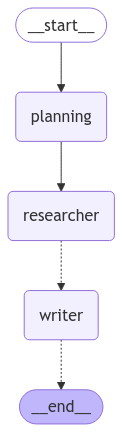

In [46]:
from IPython.display import Image, display

try:
    display(Image(video_script_app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

We have a linear process '__start__' --> 'planning' --> 'researcher' --> 'writer' --> '__end__' which starts to look like something we could do in real-life. You see that the edges are not the same (continuous versus dotted line) showing the two approach.

So we are not in an agentic workflow yet as each step is know and no agent decide what will come next. But we have already moved away from le llm-chain paradigm. 

Let's run the graph now.

In [47]:
prompt = ("I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!'")

config = {"configurable": {"thread_id": "1"}}

example_input = {
    "messages": [("human", prompt)],
}

# Collect all steps from the astream generator
steps = [step for step in video_script_app.stream(example_input, config=config, stream_mode="values")]

# Access the last step
last_step = steps[-1]

print(f"Directive: '{prompt}'")

# Print the last message of the last step
last_message = last_step["messages"][-1]

output = last_message.pretty_repr()
print(f"Result: '{output}'")


Directive: 'I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!''
Result: '================================== Ai Message ==================================
Name: writer

# Script

Imagine a world where machines do all the work. Sounds scary, right? But what if I told you that AI won't take your jobs. Those who use AI will! AI is not scary, its here to stay and it is a tool.  AI is the new electric power. AI is a tool to amplify human abilities. In various industries, AI is being used to automate tasks, analyze data, and make decisions. For example, in healthcare, AI is used to diagnose diseases, in finance, AI is used to detect fraud, and in retail, AI is used to personalize shopping experiences. AI will create more jobs than it will replace. AI will create new jobs, like AI ethicists, AI trainers, and AI engineers. AI will augment existing jobs, making them more efficient and effective. AI will transform industries, creating new opp

What's important here is ```config = {"configurable": {"thread_id": "1"}}```

You have to define a **'thread_id'** for each user. This is mandatory because StateGraph is statefull. You remember the 'MemorySaver' we have added when we compile the graph. So you have to identify the user uniquely.

LangChain use **'session_id'** to handle conversation history per user. So you'll have to initialize both value if you are using advanced chain like *'RunnableWithMessageHistory'*. 

So if you are already using LC, take care: LC and LG does not use the same *keyword* for memory management.

In this notebook, we can simply use 1 as value but for real application you will probably have a code like:

```python
import uuid

thread_id = config.configurable.get("thread_id") if config and hasattr(config, 'configurable') else str(uuid.uuid4())
```

uuid helps to generate unique id.

2nd interesting things is that langgraph work per step (and handle everything smoothly for you). It will orchestrate the call between all agent. We won't go into the detail of what is going while langgraph is executing the process. Here, we just retrieve the last step and display the last message.

StateGraph is also a runnable (like LangChain chain) so you have all the nice feature with async calling, streaming, batching etc. You also have access granularly to all events during execution to display progress to user.

## Chapter 7: Agentic Evaluation and Simulation

Like agent, you have to test you agentic worklow. Here we will use the same strategy has research but for final script. For conversational agent, you will use a [Simulator agent](https://langchain-ai.github.io/langgraph/tutorials/chatbot-simulation-evaluation/agent-simulation-evaluation/) that will replace the human interaction. As we have a fully automatized process, we just evaluate the final results. Also I recommend to set up more advanced test 

In [48]:
script_evaluator_prompt = ChatPromptTemplate.from_template("""
You are evaluating a submitted script based on the given request. 

Here is the evaluation data:
[BEGIN DATA]  
************  
<Request>
{input}
</Request>
************  
<SubmittedScript>
{response}
</SubmittedScript>
************
[END DATA]  

Compare the submitted script with the request.  
Ignore differences in style, minor phrasing, or wording variations.  

Assess alignment based on:  
- **Structure**: Does it follow a logical **chapitrage** (proposed agenda)?  
- **Angle**: Does the story perspective fit the topic?  
- **Length & Duration**: Is it reasonably aligned with expectations?  
- **Language**: Does the script is in the expected language (same as request if user not specify)?  
- **Quality**: Is it coherent, engaging, and suitable for a YouTube AI audience?  

**Grade the result:**  
- **8 to 10**: Fully meets the request across all aspects.  
- **6 to 8**: Mostly aligned, with minor gaps.  
- **4 to 6**: Partially aligned, missing key aspects.  
- **2 to 4**: Significant misalignment with the request.  
- **0 to 2**: Off-topic or completely missing expectations.  
If the submission is entirely missing or contains no meaningful content (ex: None), assign a score of 0.
The script is **ACCEPTABLE** if the score is above 6. It is **UNACCEPTABLE** if the score is below 6.  

**Answer format:**  
Grade: <ACCEPTABLE or UNACCEPTABLE>  
Score: <grade from 0 to 10>"**  
Comment: <Brief justification for the score, highlighting any gaps or misalignment>  
""")

In [49]:
import uuid

script_evaluator = script_evaluator_prompt | llm.with_structured_output(ScriptEvaluatorFeedback)


def valid_script(input: str, output: str) -> ScriptEvaluatorFeedback:
  """Use an LLM to judge if the script is consistent."""

  res = script_evaluator.invoke(input={"input": input, "response": output})
  return res


def test_script(agent, input):

    thread_id = config.configurable.get("thread_id") if config and hasattr(config, 'configurable') else str(
        uuid.uuid4())

    effective_config = {"configurable": {"thread_id": thread_id}, "recursion_limit": 99}

    input_data = {'messages': [HumanMessage(content=input)],}

    steps = [step for step in agent.stream(input=input_data, config=effective_config, stream_mode="values")]

    # Access the last step
    last_step = steps[-1]

    # Print the last message of the last step
    last_message = last_step["messages"][-1]
    output = last_message.pretty_repr()

    # output = agent.invoke(input={"messages": input})

    res = valid_script(input, output)

    assert res["Grade"], "Acceptable"
    return res


In [50]:
test_script(video_script_app, prompt)

{'Grade': 'ACCEPTABLE',
 'Score': 8,
 'Comment': 'The script is well-aligned with the request. It follows a logical structure with two chapters as requested, covering the impact of AI on the job market and how to leverage AI for career enhancement. The angle is appropriate, focusing on the positive aspects of AI in the job market. The length and duration are reasonably aligned with the expectation of a 2-minute, 450-word video script. The language is clear and suitable for a YouTube AI audience. However, there are minor gaps in the script; it could benefit from more specific examples and actionable advice to fully meet the request.'}

This is basic testing but it is very simple to implement and as your workflow start to complexify, you must have a robust testing strategy in place from the beggining.

If you look carefully at the test_script function, you'll notice that I've added a **"recursion_limit"** parameter to the configurable.
This is very important as from now we will add 'branch' and 'loop' in our graph and we doesn't not want our workflow go into infinite loop (as the logic and decision will be handled by autonomous agents). So **'recursion_limit'** will avoid our AI Agent go crazy and stop before consuming all our credits.

# Chapter 8: Supervisor node

First, we will add a new member in the script writing team: **'reviewer'**.

Reviewer will be in charge to check the quality of the research and the script and give advice for enhance. He will advice if the work must be done by research if more input is needed or writer if only style or structure revision is required. He will also 'approved' the script if it is ok. 

But for good measure, we will redeclare import in one cell so we won't have to search for them.

In [53]:
# redeclaring import here to avoir searching in different cells.
from typing import TypedDict, Literal, Annotated, List,  Tuple

from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.graph.message import add_messages
from langchain_core.messages import  BaseMessage

from langchain import hub
from langsmith.utils import LangSmithConflictError

import operator

from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.memory import MemorySaver

In [64]:
class ReviewFeedback(TypedDict):
    GoodPoints: str
    MissingOrNeedsResearch: str
    SuperfluousContent: str
    StyleRefinement: str
    NextNode: Literal['researcher', 'writer', 'approved']

review_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the `Reviewer` in a team responsible for scriptwriting YouTube videos.\n\n"
            """Based solely on the proposed key topics and brief from the agenda and writing guidelines,
            your task is to evaluate the script draft and provide concise and structured feedback in four parts:

            1. **GoodPoints**: List the positive aspects that should be retained.
            2. **MissingOrNeedsResearch**: Specify missing information or areas that require more research.
            3. **SuperfluousContent**: Identify anything unnecessary or off-topic in the chapter.
            4. **StyleRefinement**: Major issues with writing guidelines such as word counts per chapter or repetition.
            5. **NextNode**: Indicate the next action by choosing one of:
               - 'approved': If no major revisions or research are necessary.
               - 'writer': If Superfluous Content or Style Refinement BUT NO NEW CONTENT.
               - 'research': If Missing Or Needs Research to address gaps or improve accuracy from the agenda.

            ---

            ### **Decision-Making Guidance for NextNode**:
            1. Choose **'approved'** (default) if issues are minor or stylistic.
            2. Choose **'writer'** if structural or stylistic improvements are required AND NO NEW content is required.
            3. Choose **'research'** if missing content.
            **IMPORTANT**: 'writer' cannot do his own research. Go to 'research' any time new content is necessary.
            In case of ambiguity or perplexity, choose 'research'.
            ---
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reviewer = review_prompt | llm.with_structured_output(ReviewFeedback)

Nothing particular to comment here.

Let's define the **'reviewer_node'**.

In [65]:
def reviewer_node(state: VideoScriptState) -> Command[Literal["supervisor"]]:
    """
    The 'Reviewer' agent checks the current draft:
      - If acceptable, we finalize the chapter.
      - If not acceptable, we request changes => 'draft_node' or 'researcher_node' again.
    """

    human_message = HumanMessage(content=f"Review the draft of the chapter", name="user")
    messages = state["messages"] + [human_message]

    res = reviewer.invoke(input={"messages": messages})

    reviewer_message_content = (
        f"# Reviewer Feedback\n\n"
        f"Good Points:\n {res['GoodPoints']}\n\n"
        f"Missing or Needs Research:\n {res['MissingOrNeedsResearch']}\n\n"
        f"Superfluous Content:\n {res['SuperfluousContent']}\n\n"
        f"Style Refinement:\n {res['StyleRefinement']}\n\n"
        f"next: {res['NextNode']}\n\n"
    )

    return Command(
        update={
            "messages": [AIMessage(content=reviewer_message_content, name="reviewer")],
            "next": res["NextNode"],
        },
        goto="supervisor",
    )

'Reviewer' gives feedback on the quality of the script revision (good points) to keep it and what is missing or need to be change.

We have also ask reviewer to give what he estimates to be the 'best' next node that the supervisor should redirect or if he approves the last iteration of the script. For example, we only need style revision, no need to do new research. But if content is missing, we should look for it with the research agent.

In real-case scenario, you will have to give 'Guidelines' to each agent to ensure a coherency in style/tone/structure, etc... and avoid infinite revision.

The next agent will be pass through the State of the graph so we add the field **'next'** in it.

In [56]:
class VideoScriptState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    chapters: List[Chapter]
    next: Literal['researcher', 'writer', 'approved']
    past_steps: Annotated[List[Tuple], operator.add]

Now we will create a supervisor node that will orchestate the job between each agent chapter per chapter.

In [73]:
members = ["researcher", "writer", "reviewer"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the initial user request and advice from reviewer,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and comments. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]



def supervisor_node(state: VideoScriptState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    host_message = HumanMessage(content="What to do next?", name="host-producer")
    messages += [host_message]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": ""})

Now we update each participants to go back to supervisor

In [58]:
def researcher_node(state: VideoScriptState) -> Command[Literal["writer"]]:
    """
    The Researcher provides factual data/ideas for the current chapter.
    For demonstration, we just append a dummy 'AIMessage' with bullet points.
    """
    chapters = state["chapters"]
    message_content = f"Provide research for the video covering the key topics of agenda."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = researcher.invoke(input={"messages": messages})

    research_response_comment = res.get('comment', 'No comment provided.')
    research_chapter_content = res['research']
    research_message_content = (f"# Research"
                                f"\n\n{research_chapter_content}"
                                f"\n\n-----\n\n#Comment"
                                f"\n\n{research_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=research_message_content, name="researcher")],
        },
        goto="writer",
    )

In [59]:
def writer_node(state: VideoScriptState) -> Command[Literal["reviewer"]]:
    """
    The Writer composes or updates the script for the current chapter using the research input.
    """
    chapters = state["chapters"]
    message_content = f"Write the script using agenda and research."
    human_message = HumanMessage(content=message_content, name="user")
    messages = state["messages"] + [human_message]

    res = writer.invoke(input={"messages": messages})

    # Check if 'comment' is in the response
    writer_script_content = res['script']
    writer_response_comment = res.get('comment', 'No comment provided.')

    writer_message_content = (f"# Script"
                              f"\n\n{writer_script_content}\n\n-----"
                              f"\n\n# Writer Comment"
                              f"\n\n{writer_response_comment}")

    return Command(
        update={
            "messages": [AIMessage(content=writer_message_content, name="writer")],
        },
        goto="reviewer",
    )

And 'planner node' if it need some tweacking.

In [60]:
def planner_node(state: VideoScriptState) -> VideoScriptState:
    """
    The Host/Producer sets the plan (how many chapters, the overall direction).
    In a real scenario, you'd call host_producer_prompt with the user request to produce an agenda.
    We'll simulate it here.
    """
    # If not already done, let's define chapters in the conversation or from user input
    # Example simulation: The user wants a 3-chapter video, so we store that:
    if not state.get("chapters"):

        planner_prompt = hub.pull("tuto-video-script-planner-prompt")
        message_content = planner_prompt.format()
        messages = state["messages"] + [HumanMessage(content=message_content, name="user")]
        res = planner.invoke(input={"messages": messages})
        chapters = res['plan']
        state["chapters"] = chapters
        formatted_chapters = _format_chapters(chapters)
        producer_message = (f"Here's a suggested agenda for your video."
                            f"\n\n{formatted_chapters}")
        host_message = HumanMessage(content=producer_message, name="host-producer")
        state["messages"].append(host_message)
        state["next"] = 'research'
    return state

In [74]:
workflow = StateGraph(VideoScriptState)
workflow.add_node("planning", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_node("reviewer", reviewer_node)
workflow.add_node("supervisor", supervisor_node)
workflow.add_edge(START, "planning")
workflow.add_edge("planning", "supervisor")

memory = MemorySaver()
video_script_workflow = workflow.compile(checkpointer=memory)

Let's display it.

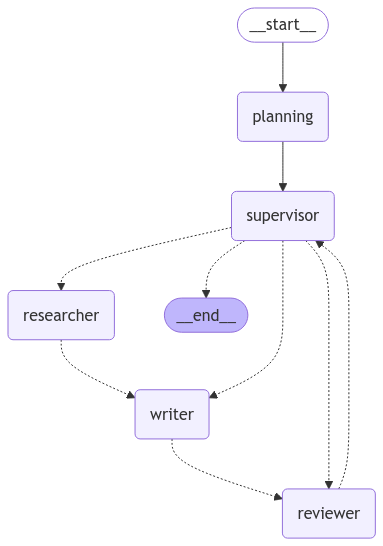

In [71]:
from IPython.display import Image, display

try:
    display(Image(video_script_workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we are getting some serious stuff. 

Now that we have a real agentic workflow with agent that take decision to the next action, don't forget to add ```"recursion_limit"```to configurable. 99 here is absolutely arbitrary. Adapt it to your needs.

Let's test it.

In [77]:
prompt = ("I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!'")

config = {"configurable": {"thread_id": "1", "recursion_limit": 99}}

example_input = {
    "messages": [("human", prompt)],
}

# Collect all steps from the astream generator
steps = [step for step in video_script_workflow.stream(example_input, config=config, stream_mode="values")]

# Access the last step
last_step = steps[-1]

print(f"Directive: '{prompt}'")

# Print the last message of the last step
last_message = last_step["messages"][-1]

output = last_message.pretty_repr()
print(f"Result: '{output}'")


Directive: 'I'd like a 2-chapter video of 2 minutes of 450 words on 'AI Won't Take Your Jobs. Those Who Use AI Will!''
Result: '================================== Ai Message ==================================
Name: reviewer

# Reviewer Feedback

Good Points:
 Engaging opening and closing statements. The script is well-organized with logical flow between sections. The examples provided for AI in daily life and various industries are interesting and relevant. The emphasis on continuous learning and ethical AI use is well-placed. The inclusion of specific reports and statistics from credible sources adds credibility. Clear and concise language.

Missing or Needs Research:
 The opening section could be enhanced with a more compelling hook or a surprising statistic to immediately grab the audience's attention. The transition between chapters could be smoother; consider using bridging sentences to connect the ideas more fluidly. More concrete examples of AI tools and their practical applicat

# TODO 
- expliquer le role de thread_id pour la mémoire et qu'il y a aussi l'id de langchain. Ici c'est statique mais il faut le gérer dans de vrai cas d'usage
- Expliquer l'Intéret de Mistral small 3 qui fonctionne très bien avec de longue conversation et qui avait tendance à ne plus générer le format structuré. Plus de soucis maintenant.
- Mais dans ce cas montrer la partie policy
- Quand on passe sur une boucle montrer le max itération
- Présenter le thread_id avec uuid.

- Passage en supervisor
- Un petit exemple avec un appel de fonction (RAG) ou autre chose que langchain ?
  